# records

In [1]:
import vectorbt as vbt

In [2]:
import numpy as np
import pandas as pd
from numba import njit
from collections import namedtuple

In [3]:
# Disable caching for performance testing
# NOTE: Expect waterfall of executions, since some attributes depend on other attributes 
# that have to be calculated again and again
vbt.defaults.caching = False

In [4]:
example_dt = np.dtype([
    ('col', np.int64),
    ('idx', np.int64),
    ('some_field1', np.float64),
    ('some_field2', np.float64)
], align=True)

In [5]:
records_arr = np.asarray([
    (0, 0, 10, 21),
    (0, 1, 11, 22),
    (0, 2, 12, 23),
    (1, 0, 13, 24),
    (1, 1, 14, 25),
    (1, 2, 15, 26),
    (2, 0, 16, 27),
    (2, 1, 17, 28),
    (2, 2, 18, 29)
], dtype=example_dt)
print(records_arr)
print(records_arr.shape)
wrapper = vbt.timeseries.common.TSArrayWrapper(index=['x', 'y', 'z'], columns=['a', 'b', 'c', 'd'], ndim=2)
records = vbt.records.Records(records_arr, wrapper)

[(0, 0, 10., 21.) (0, 1, 11., 22.) (0, 2, 12., 23.) (1, 0, 13., 24.)
 (1, 1, 14., 25.) (1, 2, 15., 26.) (2, 0, 16., 27.) (2, 1, 17., 28.)
 (2, 2, 18., 29.)]
(9,)


In [6]:
big_records_arr = np.asarray(list(zip(*(
    np.repeat(np.arange(1000), 1000),
    np.tile(np.arange(1000), 1000),
    np.random.uniform(size=1000000),
    np.random.uniform(size=1000000)))), dtype=example_dt)
print(big_records_arr.shape)
big_wrapper = vbt.timeseries.common.TSArrayWrapper(index=np.arange(1000), columns=np.arange(1000), ndim=2)
big_records = vbt.records.Records(big_records_arr, big_wrapper)

(1000000,)


In [7]:
print(records.records_arr)

print(records.recarray)
%timeit big_records.recarray

[(0, 0, 10., 21.) (0, 1, 11., 22.) (0, 2, 12., 23.) (1, 0, 13., 24.)
 (1, 1, 14., 25.) (1, 2, 15., 26.) (2, 0, 16., 27.) (2, 1, 17., 28.)
 (2, 2, 18., 29.)]
[(0, 0, 10., 21.) (0, 1, 11., 22.) (0, 2, 12., 23.) (1, 0, 13., 24.)
 (1, 1, 14., 25.) (1, 2, 15., 26.) (2, 0, 16., 27.) (2, 1, 17., 28.)
 (2, 2, 18., 29.)]
6.24 µs ± 77.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [8]:
print(records.records)

   col  idx  some_field1  some_field2
0    0    0         10.0         21.0
1    0    1         11.0         22.0
2    0    2         12.0         23.0
3    1    0         13.0         24.0
4    1    1         14.0         25.0
5    1    2         15.0         26.0
6    2    0         16.0         27.0
7    2    1         17.0         28.0
8    2    2         18.0         29.0


In [9]:
print(records.records_col_index)

%timeit big_records.records_col_index

[[ 0  3]
 [ 3  6]
 [ 6  9]
 [-1 -1]]
2.04 ms ± 85 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
print(records.map_field_to_matrix('col'))
print(records.map_field_to_matrix('idx'))
print(records.map_field_to_matrix('some_field1'))
print(records.map_field_to_matrix('some_field2'))
print(records.map_field_to_matrix('some_field2', default_val=0.))

%timeit big_records.map_field_to_matrix('some_field1')

     a    b    c   d
x  0.0  1.0  2.0 NaN
y  0.0  1.0  2.0 NaN
z  0.0  1.0  2.0 NaN
     a    b    c   d
x  0.0  0.0  0.0 NaN
y  1.0  1.0  1.0 NaN
z  2.0  2.0  2.0 NaN
      a     b     c   d
x  10.0  13.0  16.0 NaN
y  11.0  14.0  17.0 NaN
z  12.0  15.0  18.0 NaN
      a     b     c   d
x  21.0  24.0  27.0 NaN
y  22.0  25.0  28.0 NaN
z  23.0  26.0  29.0 NaN
      a     b     c    d
x  21.0  24.0  27.0  0.0
y  22.0  25.0  28.0  0.0
z  23.0  26.0  29.0  0.0
6.01 ms ± 200 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
@njit
def map_func_nb(record):
    return record.some_field1 + record.some_field2

print(records.map_records_to_matrix(map_func_nb))
print(records.map_records_to_matrix(map_func_nb, default_val=0.))

%timeit big_records.map_records_to_matrix(map_func_nb)

      a     b     c   d
x  31.0  37.0  43.0 NaN
y  33.0  39.0  45.0 NaN
z  35.0  41.0  47.0 NaN
      a     b     c    d
x  31.0  37.0  43.0  0.0
y  33.0  39.0  45.0  0.0
z  35.0  41.0  47.0  0.0
5.97 ms ± 303 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
print(records.convert_array_to_matrix(records_arr['some_field1'] + records_arr['some_field2']))
print(records.convert_array_to_matrix(records_arr['some_field1'] + records_arr['some_field2'], default_val=0.))

%timeit big_records.convert_array_to_matrix(big_records_arr['some_field1'] + big_records_arr['some_field2'])
# slow, only good for mapping single columns

      a     b     c   d
x  31.0  37.0  43.0 NaN
y  33.0  39.0  45.0 NaN
z  35.0  41.0  47.0 NaN
      a     b     c    d
x  31.0  37.0  43.0  0.0
y  33.0  39.0  45.0  0.0
z  35.0  41.0  47.0  0.0
10.4 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
@njit
def reduce_func1_nb(records):
    return np.mean(records.some_field1 + records.some_field2)

print(records.reduce_records(reduce_func1_nb))
print(records.reduce_records(reduce_func1_nb, default_val=0.))

%timeit big_records.reduce_records(reduce_func1_nb)

a    33.0
b    39.0
c    45.0
d     NaN
dtype: float64
a    33.0
b    39.0
c    45.0
d     0.0
dtype: float64
4.12 ms ± 40.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
@njit
def reduce_func2_nb(a):
    return np.mean(a)

print(records.map_reduce_records(map_func_nb, reduce_func2_nb))
print(records.map_reduce_records(map_func_nb, reduce_func2_nb, default_val=0.))

%timeit big_records.map_reduce_records(map_func_nb, reduce_func2_nb) # slower but more flexible

a    33.0
b    39.0
c    45.0
d     NaN
dtype: float64
a    33.0
b    39.0
c    45.0
d     0.0
dtype: float64
5.16 ms ± 123 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
print(records.count)

%timeit big_records.count

a    3.0
b    3.0
c    3.0
d    0.0
dtype: float64
2.19 ms ± 53.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
print(records['a'].records)
print(records['a'].wrapper.columns)
print(records['b'].records)
print(records['b'].wrapper.columns)

%timeit big_records.iloc[:, 0]
%timeit big_records.iloc[:, :]

   col  idx  some_field1  some_field2
0    0    0         10.0         21.0
1    0    1         11.0         22.0
2    0    2         12.0         23.0
Index(['a'], dtype='object')
   col  idx  some_field1  some_field2
0    0    0         13.0         24.0
1    0    1         14.0         25.0
2    0    2         15.0         26.0
Index(['b'], dtype='object')
2.7 ms ± 41.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
35.1 ms ± 21.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
filtered_records = vbt.records.Records(records_arr[[0, -1]], wrapper)
print(filtered_records.records)
print(filtered_records.records_col_index)

   col  idx  some_field1  some_field2
0    0    0         10.0         21.0
1    2    2         18.0         29.0
[[ 0  1]
 [-1 -1]
 [ 1  2]
 [-1 -1]]


In [18]:
print(filtered_records['a'].records)
print(filtered_records['a'].records_col_index)
print(filtered_records['a'].map_field_to_matrix('some_field1'))
print(filtered_records['a'].count)

   col  idx  some_field1  some_field2
0    0    0         10.0         21.0
[[0 1]]
x    10.0
y     NaN
z     NaN
Name: a, dtype: float64
1.0


In [19]:
print(filtered_records['b'].records)
print(filtered_records['b'].records_col_index)
print(filtered_records['b'].map_field_to_matrix('some_field1'))
print(filtered_records['b'].count)

Empty DataFrame
Columns: [col, idx, some_field1, some_field2]
Index: []
[[-1 -1]]
x   NaN
y   NaN
z   NaN
Name: b, dtype: float64
0.0


In [20]:
print(filtered_records['c'].records)
print(filtered_records['c'].records_col_index)
print(filtered_records['c'].map_field_to_matrix('some_field1'))
print(filtered_records['c'].count)

   col  idx  some_field1  some_field2
0    0    2         18.0         29.0
[[0 1]]
x     NaN
y     NaN
z    18.0
Name: c, dtype: float64
1.0


In [21]:
print(filtered_records['d'].records)
print(filtered_records['d'].records_col_index)
print(filtered_records['d'].map_field_to_matrix('some_field1'))
print(filtered_records['d'].count)

Empty DataFrame
Columns: [col, idx, some_field1, some_field2]
Index: []
[[-1 -1]]
x   NaN
y   NaN
z   NaN
Name: d, dtype: float64
0.0


## Drawdowns

In [22]:
from vectorbt.records import Drawdowns

In [23]:
ts = pd.DataFrame({
    'a': [2, 1, 3, 1, 4, 1], 
    'b': [1, 2, 1, 3, 1, 4],
    'c': [1, 2, 3, 2, 1, 2],
    'd': [1, 2, 3, 4, 5, 6]
}).astype(np.float32)

print(ts)

     a    b    c    d
0  2.0  1.0  1.0  1.0
1  1.0  2.0  2.0  2.0
2  3.0  1.0  3.0  3.0
3  1.0  3.0  2.0  4.0
4  4.0  1.0  1.0  5.0
5  1.0  4.0  2.0  6.0


In [24]:
big_ts = pd.DataFrame(np.random.randint(1, 10, size=(1000, 1000)).astype(float))
big_ts.shape

(1000, 1000)

In [25]:
drawdowns = Drawdowns.from_ts(ts, freq='1 days')
big_drawdowns = Drawdowns.from_ts(big_ts, freq='1 days')

%timeit Drawdowns.from_ts(big_ts, freq='1 days')

8.41 ms ± 96.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
print(drawdowns.records)
print(drawdowns.ts)

print(drawdowns['a'].records)
print(drawdowns['a'].ts)

print(drawdowns['b'].records)
print(drawdowns['b'].ts)

print(drawdowns['c'].records)
print(drawdowns['c'].ts)

print(drawdowns['d'].records)
print(drawdowns['d'].ts)

   col  idx  start_idx  valley_idx  end_idx  status
0    0    2          0           1        2       1
1    0    4          2           3        4       1
2    0    5          4           5        5       0
3    1    3          1           2        3       1
4    1    5          3           4        5       1
5    2    5          2           4        5       0
     a    b    c    d
0  2.0  1.0  1.0  1.0
1  1.0  2.0  2.0  2.0
2  3.0  1.0  3.0  3.0
3  1.0  3.0  2.0  4.0
4  4.0  1.0  1.0  5.0
5  1.0  4.0  2.0  6.0
   col  idx  start_idx  valley_idx  end_idx  status
0    0    2          0           1        2       1
1    0    4          2           3        4       1
2    0    5          4           5        5       0
0    2.0
1    1.0
2    3.0
3    1.0
4    4.0
5    1.0
Name: a, dtype: float32
   col  idx  start_idx  valley_idx  end_idx  status
0    0    3          1           2        3       1
1    0    5          3           4        5       1
0    1.0
1    2.0
2    1.0
3    3.0
4   

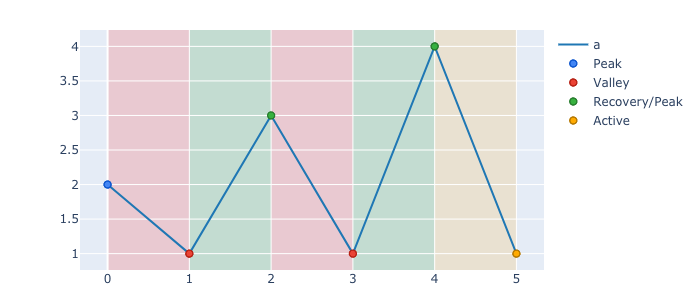

In [27]:
drawdowns['a'].plot().show_png()

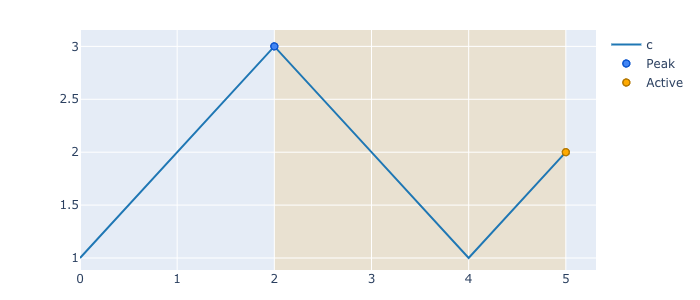

In [28]:
drawdowns['c'].plot().show_png()

In [29]:
print(drawdowns['a'].count)
print(drawdowns.count)

3.0
a    3.0
b    2.0
c    1.0
d    0.0
dtype: float64


In [30]:
print(drawdowns['a'].start_value)
print(drawdowns.start_value)

%timeit big_drawdowns.start_value

0    NaN
1    NaN
2    2.0
3    NaN
4    3.0
5    4.0
Name: a, dtype: float64
     a    b    c   d
0  NaN  NaN  NaN NaN
1  NaN  NaN  NaN NaN
2  2.0  NaN  NaN NaN
3  NaN  2.0  NaN NaN
4  3.0  NaN  NaN NaN
5  4.0  3.0  3.0 NaN
4.43 ms ± 52.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [31]:
print(drawdowns['a'].valley_value)
print(drawdowns.valley_value)

%timeit big_drawdowns.valley_value

0    NaN
1    NaN
2    1.0
3    NaN
4    1.0
5    1.0
Name: a, dtype: float64
     a    b    c   d
0  NaN  NaN  NaN NaN
1  NaN  NaN  NaN NaN
2  1.0  NaN  NaN NaN
3  NaN  1.0  NaN NaN
4  1.0  NaN  NaN NaN
5  1.0  1.0  1.0 NaN
4.46 ms ± 88.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
print(drawdowns['a'].end_value)
print(drawdowns.end_value)

%timeit big_drawdowns.end_value

0    NaN
1    NaN
2    3.0
3    NaN
4    4.0
5    1.0
Name: a, dtype: float64
     a    b    c   d
0  NaN  NaN  NaN NaN
1  NaN  NaN  NaN NaN
2  3.0  NaN  NaN NaN
3  NaN  3.0  NaN NaN
4  4.0  NaN  NaN NaN
5  1.0  4.0  2.0 NaN
4.46 ms ± 36.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
print(drawdowns['a'].drawdown)
print(drawdowns.drawdown)

%timeit big_drawdowns.drawdown

0         NaN
1         NaN
2   -0.500000
3         NaN
4   -0.666667
5   -0.750000
Name: a, dtype: float64
          a         b         c   d
0       NaN       NaN       NaN NaN
1       NaN       NaN       NaN NaN
2 -0.500000       NaN       NaN NaN
3       NaN -0.500000       NaN NaN
4 -0.666667       NaN       NaN NaN
5 -0.750000 -0.666667 -0.666667 NaN
6.66 ms ± 81.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [34]:
print(drawdowns['a'].avg_drawdown)
print(drawdowns.avg_drawdown)

%timeit big_drawdowns.avg_drawdown

-0.6388888955116272
a   -0.638889
b   -0.583333
c   -0.666667
d         NaN
dtype: float64
4.25 ms ± 149 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
print(drawdowns['a'].max_drawdown)
print(drawdowns.max_drawdown)

%timeit big_drawdowns.max_drawdown

-0.75
a   -0.750000
b   -0.666667
c   -0.666667
d         NaN
dtype: float64
4.17 ms ± 220 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
print(drawdowns['a'].duration)
print(drawdowns.duration)

%timeit big_drawdowns.duration

0    NaN
1    NaN
2    2.0
3    NaN
4    2.0
5    1.0
Name: a, dtype: float64
     a    b    c   d
0  NaN  NaN  NaN NaN
1  NaN  NaN  NaN NaN
2  2.0  NaN  NaN NaN
3  NaN  2.0  NaN NaN
4  2.0  NaN  NaN NaN
5  1.0  2.0  3.0 NaN
3.07 ms ± 39.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
print(drawdowns['a'].avg_duration)
print(drawdowns.avg_duration)

%timeit big_drawdowns.avg_duration

1 days 16:00:00
a   1 days 16:00:00
b   2 days 00:00:00
c   3 days 00:00:00
d               NaT
dtype: timedelta64[ns]
8.2 ms ± 153 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [38]:
print(drawdowns['a'].max_duration)
print(drawdowns.max_duration)

%timeit big_drawdowns.max_duration

2 days 00:00:00
a   2 days
b   2 days
c   3 days
d      NaT
dtype: timedelta64[ns]
8.01 ms ± 225 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [39]:
print(drawdowns['a'].coverage)
print(drawdowns.coverage)

%timeit big_drawdowns.coverage

0.8333333333333334
a    0.833333
b    0.666667
c    0.500000
d    0.000000
dtype: float64
826 µs ± 11.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [40]:
print(drawdowns['a'].ptv_duration)
print(drawdowns.ptv_duration)

%timeit big_drawdowns.ptv_duration

0    NaN
1    NaN
2    1.0
3    NaN
4    1.0
5    1.0
Name: a, dtype: float64
     a    b    c   d
0  NaN  NaN  NaN NaN
1  NaN  NaN  NaN NaN
2  1.0  NaN  NaN NaN
3  NaN  1.0  NaN NaN
4  1.0  NaN  NaN NaN
5  1.0  1.0  2.0 NaN
3.11 ms ± 47.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [41]:
print(drawdowns['a'].status)
print(drawdowns.status)

%timeit big_drawdowns.status

0    NaN
1    NaN
2    1.0
3    NaN
4    1.0
5    0.0
Name: a, dtype: float64
     a    b    c   d
0  NaN  NaN  NaN NaN
1  NaN  NaN  NaN NaN
2  1.0  NaN  NaN NaN
3  NaN  1.0  NaN NaN
4  1.0  NaN  NaN NaN
5  0.0  1.0  0.0 NaN
3.04 ms ± 41.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [42]:
print(drawdowns['a'].recovered_rate)
print(drawdowns.recovered_rate)

%timeit big_drawdowns.recovered_rate

0.6666666666666666
a    0.666667
b    1.000000
c    0.000000
d         NaN
dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/records/drawdowns.py:375: RuntimeWarning:

invalid value encountered in true_divide



3.98 ms ± 119 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [43]:
print(drawdowns['a'].active.records)
print(drawdowns.active['a'].records)
print(drawdowns.active.records)

   col  idx  start_idx  valley_idx  end_idx  status
0    0    5          4           5        5       0
   col  idx  start_idx  valley_idx  end_idx  status
0    0    5          4           5        5       0
   col  idx  start_idx  valley_idx  end_idx  status
0    0    5          4           5        5       0
1    2    5          2           4        5       0


In [44]:
print(drawdowns['a'].recovered.records)
print(drawdowns.recovered['a'].records)
print(drawdowns.recovered.records)

   col  idx  start_idx  valley_idx  end_idx  status
0    0    2          0           1        2       1
1    0    4          2           3        4       1
   col  idx  start_idx  valley_idx  end_idx  status
0    0    2          0           1        2       1
1    0    4          2           3        4       1
   col  idx  start_idx  valley_idx  end_idx  status
0    0    2          0           1        2       1
1    0    4          2           3        4       1
2    1    3          1           2        3       1
3    1    5          3           4        5       1


In [45]:
%timeit big_drawdowns.active

427 µs ± 10.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [46]:
%timeit big_drawdowns.recovered

2.59 ms ± 25.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [47]:
print(drawdowns['a'].recovered.recovery_return)
print(drawdowns.recovered.recovery_return)

%timeit big_drawdowns.recovered.recovery_return

0    NaN
1    NaN
2    2.0
3    NaN
4    3.0
5    NaN
Name: a, dtype: float64
     a    b   c   d
0  NaN  NaN NaN NaN
1  NaN  NaN NaN NaN
2  2.0  NaN NaN NaN
3  NaN  2.0 NaN NaN
4  3.0  NaN NaN NaN
5  NaN  3.0 NaN NaN
10.2 ms ± 87 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [48]:
print(drawdowns['a'].recovered.vtr_duration)
print(drawdowns.recovered.vtr_duration)

%timeit big_drawdowns.recovered.vtr_duration

0    NaN
1    NaN
2    1.0
3    NaN
4    1.0
5    NaN
Name: a, dtype: float64
     a    b   c   d
0  NaN  NaN NaN NaN
1  NaN  NaN NaN NaN
2  1.0  NaN NaN NaN
3  NaN  1.0 NaN NaN
4  1.0  NaN NaN NaN
5  NaN  1.0 NaN NaN
6.83 ms ± 268 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [49]:
print(drawdowns['a'].recovered.vtr_duration_ratio)
print(drawdowns.recovered.vtr_duration_ratio)

%timeit big_drawdowns.recovered.vtr_duration_ratio

0    NaN
1    NaN
2    0.5
3    NaN
4    0.5
5    NaN
Name: a, dtype: float64
     a    b   c   d
0  NaN  NaN NaN NaN
1  NaN  NaN NaN NaN
2  0.5  NaN NaN NaN
3  NaN  0.5 NaN NaN
4  0.5  NaN NaN NaN
5  NaN  0.5 NaN NaN
6.6 ms ± 41.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Orders

In [50]:
from vectorbt.records import Orders, order_dt

In [51]:
from datetime import datetime
price = pd.DataFrame({
    'a': [1, 2, 3, 4, 5, 6, 7],
    'b': [9, 8, 7, 6, 5, 4, 3],
    'c': [1, 2, 3, 4, 3, 2, 1],
    'd': [4, 3, 2, 1, 2, 3, 4]
}).astype(float)
print(price.shape)

big_price = pd.DataFrame(np.random.uniform(1, 10, size=(1000, 1000)).astype(float))
print(big_price.shape)

(7, 4)
(1000, 1000)


In [52]:
records_arr = np.asarray([
    (0, 2, 33.00330033, 3., 0.99009901, 0),
    (0, 3, 33.00330033, 4., 1.32013201, 1),
    (0, 4, 25.8798157, 5., 1.29399079, 0),
    (0, 6, 25.8798157, 7., 1.8115871, 1),
    (1, 2, 14.14427157, 7., 0.99009901, 0),
    (1, 3, 14.14427157, 6., 0.84865629, 1),
    (1, 4, 16.63702438, 5., 0.83185122, 0),
    (1, 5, 16.63702438, 4., 0.66548098, 1),
    (2, 0, 99.00990099, 1., 0.99009901, 0),
    (2, 1, 99.00990099, 2., 1.98019802, 1),
    (2, 6, 194.09861778, 1., 1.94098618, 0),
    (3, 2, 49.5049505, 2., 0.99009901, 0),
    (3, 4, 49.5049505, 2., 0.99009901, 1),
    (3, 6, 24.26232722, 4., 0.97049309, 0)
], dtype=order_dt)
print(records_arr.shape)
orders = Orders(records_arr, price, freq='1 days')

(14,)


In [53]:
big_records_arr = np.asarray(list(zip(*(
    np.repeat(np.arange(1000), 1000),
    np.tile(np.arange(1000), 1000),
    np.full(1000000, 10),
    np.random.uniform(1, 10, size=1000000),
    np.full(1000000, 1),
    np.full(1000000, 1)
))), dtype=order_dt)
big_records_arr['side'][::2] = 0
print(big_records_arr.shape)
big_orders = vbt.records.Orders(big_records_arr, big_price, freq='1 days')

(1000000,)


In [54]:
print(orders.records)
print(orders['a'].records)
print(orders['b'].records)
print(orders['c'].records)
print(orders['d'].records)

    col  idx        size  price      fees  side
0     0    2   33.003300    3.0  0.990099     0
1     0    3   33.003300    4.0  1.320132     1
2     0    4   25.879816    5.0  1.293991     0
3     0    6   25.879816    7.0  1.811587     1
4     1    2   14.144272    7.0  0.990099     0
5     1    3   14.144272    6.0  0.848656     1
6     1    4   16.637024    5.0  0.831851     0
7     1    5   16.637024    4.0  0.665481     1
8     2    0   99.009901    1.0  0.990099     0
9     2    1   99.009901    2.0  1.980198     1
10    2    6  194.098618    1.0  1.940986     0
11    3    2   49.504950    2.0  0.990099     0
12    3    4   49.504950    2.0  0.990099     1
13    3    6   24.262327    4.0  0.970493     0
   col  idx       size  price      fees  side
0    0    2  33.003300    3.0  0.990099     0
1    0    3  33.003300    4.0  1.320132     1
2    0    4  25.879816    5.0  1.293991     0
3    0    6  25.879816    7.0  1.811587     1
   col  idx       size  price      fees  side
0   

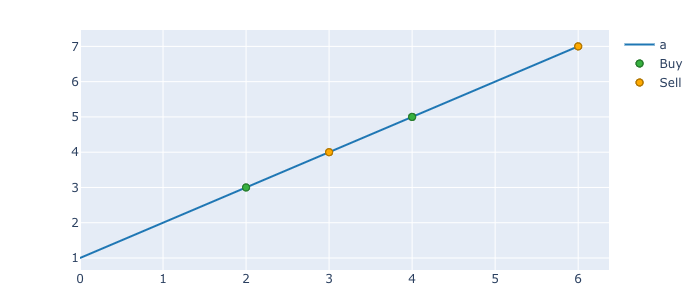

In [55]:
orders['a'].plot().show_png()

In [56]:
print(orders['a'].size)
print(orders.size)

%timeit big_orders.size

0          NaN
1          NaN
2    33.003300
3    33.003300
4    25.879816
5          NaN
6    25.879816
Name: a, dtype: float64
           a          b           c          d
0        NaN        NaN   99.009901        NaN
1        NaN        NaN   99.009901        NaN
2  33.003300  14.144272         NaN  49.504950
3  33.003300  14.144272         NaN        NaN
4  25.879816  16.637024         NaN  49.504950
5        NaN  16.637024         NaN        NaN
6  25.879816        NaN  194.098618  24.262327
7.41 ms ± 134 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [57]:
print(orders['a'].avg_size)
print(orders.avg_size)

%timeit big_orders.avg_size

29.441558015
a     29.441558
b     15.390648
c    130.706140
d     41.090743
dtype: float64
5.96 ms ± 14.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [58]:
print(orders['a'].total_size)
print(orders.total_size)

%timeit big_orders.total_size

117.76623206
a    117.766232
b     61.562592
c    392.118420
d    123.272228
dtype: float64
5.92 ms ± 98.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [59]:
print(orders['a'].price)
print(orders.price)

%timeit big_orders.price

0    NaN
1    NaN
2    3.0
3    4.0
4    5.0
5    NaN
6    7.0
Name: a, dtype: float64
     a    b    c    d
0  NaN  NaN  1.0  NaN
1  NaN  NaN  2.0  NaN
2  3.0  7.0  NaN  2.0
3  4.0  6.0  NaN  NaN
4  5.0  5.0  NaN  2.0
5  NaN  4.0  NaN  NaN
6  7.0  NaN  1.0  4.0
7.31 ms ± 53.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [60]:
print(orders['a'].avg_price)
print(orders.avg_price)

%timeit big_orders.avg_price

4.75
a    4.750000
b    5.500000
c    1.333333
d    2.666667
dtype: float64
5.96 ms ± 47.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [61]:
print(orders['a'].fees)
print(orders.fees)

%timeit big_orders.fees

0         NaN
1         NaN
2    0.990099
3    1.320132
4    1.293991
5         NaN
6    1.811587
Name: a, dtype: float64
          a         b         c         d
0       NaN       NaN  0.990099       NaN
1       NaN       NaN  1.980198       NaN
2  0.990099  0.990099       NaN  0.990099
3  1.320132  0.848656       NaN       NaN
4  1.293991  0.831851       NaN  0.990099
5       NaN  0.665481       NaN       NaN
6  1.811587       NaN  1.940986  0.970493
7.32 ms ± 53.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [62]:
print(orders['a'].avg_fees)
print(orders.avg_fees)

%timeit big_orders.avg_fees

1.3539522275
a    1.353952
b    0.834022
c    1.637094
d    0.983564
dtype: float64
6.09 ms ± 80.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [63]:
print(orders['a'].total_fees)
print(orders.total_fees)

%timeit big_orders.total_fees

5.41580891
a    5.415809
b    3.336087
c    4.911283
d    2.950691
dtype: float64
6 ms ± 67.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [64]:
print(orders['a'].side)
print(orders.side)

%timeit big_orders.side

0    NaN
1    NaN
2    0.0
3    1.0
4    0.0
5    NaN
6    1.0
Name: a, dtype: float64
     a    b    c    d
0  NaN  NaN  0.0  NaN
1  NaN  NaN  1.0  NaN
2  0.0  0.0  NaN  0.0
3  1.0  1.0  NaN  NaN
4  0.0  0.0  NaN  1.0
5  NaN  1.0  NaN  NaN
6  1.0  NaN  0.0  0.0
7.94 ms ± 413 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [65]:
print(orders['a'].buy.records)
print(orders.buy['a'].records)
print(orders.buy.records)

   col  idx       size  price      fees  side
0    0    2  33.003300    3.0  0.990099     0
1    0    4  25.879816    5.0  1.293991     0
   col  idx       size  price      fees  side
0    0    2  33.003300    3.0  0.990099     0
1    0    4  25.879816    5.0  1.293991     0
   col  idx        size  price      fees  side
0    0    2   33.003300    3.0  0.990099     0
1    0    4   25.879816    5.0  1.293991     0
2    1    2   14.144272    7.0  0.990099     0
3    1    4   16.637024    5.0  0.831851     0
4    2    0   99.009901    1.0  0.990099     0
5    2    6  194.098618    1.0  1.940986     0
6    3    2   49.504950    2.0  0.990099     0
7    3    6   24.262327    4.0  0.970493     0


In [66]:
print(orders['a'].sell.records)
print(orders.sell['a'].records)
print(orders.sell.records)

   col  idx       size  price      fees  side
0    0    3  33.003300    4.0  1.320132     1
1    0    6  25.879816    7.0  1.811587     1
   col  idx       size  price      fees  side
0    0    3  33.003300    4.0  1.320132     1
1    0    6  25.879816    7.0  1.811587     1
   col  idx       size  price      fees  side
0    0    3  33.003300    4.0  1.320132     1
1    0    6  25.879816    7.0  1.811587     1
2    1    3  14.144272    6.0  0.848656     1
3    1    5  16.637024    4.0  0.665481     1
4    2    1  99.009901    2.0  1.980198     1
5    3    4  49.504950    2.0  0.990099     1


In [67]:
%timeit big_orders.buy

18.2 ms ± 3.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [68]:
%timeit big_orders.sell

The slowest run took 4.64 times longer than the fastest. This could mean that an intermediate result is being cached.
24.1 ms ± 13.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [69]:
print(orders['a'].buy.size)
print(orders.buy.size)

%timeit big_orders.buy.size

0          NaN
1          NaN
2    33.003300
3          NaN
4    25.879816
5          NaN
6          NaN
Name: a, dtype: float64
           a          b           c          d
0        NaN        NaN   99.009901        NaN
1        NaN        NaN         NaN        NaN
2  33.003300  14.144272         NaN  49.504950
3        NaN        NaN         NaN        NaN
4  25.879816  16.637024         NaN        NaN
5        NaN        NaN         NaN        NaN
6        NaN        NaN  194.098618  24.262327
24.9 ms ± 3.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [70]:
print(orders['a'].sell.size)
print(orders.sell.size)

%timeit big_orders.sell.size

0          NaN
1          NaN
2          NaN
3    33.003300
4          NaN
5          NaN
6    25.879816
Name: a, dtype: float64
           a          b          c         d
0        NaN        NaN        NaN       NaN
1        NaN        NaN  99.009901       NaN
2        NaN        NaN        NaN       NaN
3  33.003300  14.144272        NaN       NaN
4        NaN        NaN        NaN  49.50495
5        NaN  16.637024        NaN       NaN
6  25.879816        NaN        NaN       NaN
24.4 ms ± 3.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Trades

In [71]:
from vectorbt.records import Trades

In [72]:
trades = Trades.from_orders(orders)
print(trades.records_arr.shape)

(8,)


In [73]:
big_trades = Trades.from_orders(big_orders)
print(big_trades.records_arr.shape)

(500000,)


In [74]:
%timeit Trades.from_orders(big_orders)

The slowest run took 4.58 times longer than the fastest. This could mean that an intermediate result is being cached.
82.7 ms ± 37.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [75]:
print(trades.records)
print(trades['a'].records)
print(trades['b'].records)
print(trades['c'].records)
print(trades['d'].records)

   col  idx        size  open_idx  open_price  open_fees  close_idx  \
0    0    3   33.003300         2         3.0   0.990099          3   
1    0    6   25.879816         4         5.0   1.293991          6   
2    1    3   14.144272         2         7.0   0.990099          3   
3    1    5   16.637024         4         5.0   0.831851          5   
4    2    1   99.009901         0         1.0   0.990099          1   
5    2    6  194.098618         6         1.0   1.940986          6   
6    3    4   49.504950         2         2.0   0.990099          4   
7    3    6   24.262327         6         4.0   0.970493          6   

   close_price  close_fees        pnl    return  status  position_idx  
0          4.0    1.320132  30.693069  0.306931       1             0  
1          7.0    1.811587  48.654054  0.372277       1             1  
2          6.0    0.848656 -15.983027 -0.159830       1             2  
3          4.0    0.665481 -18.134357 -0.215842       1             3  


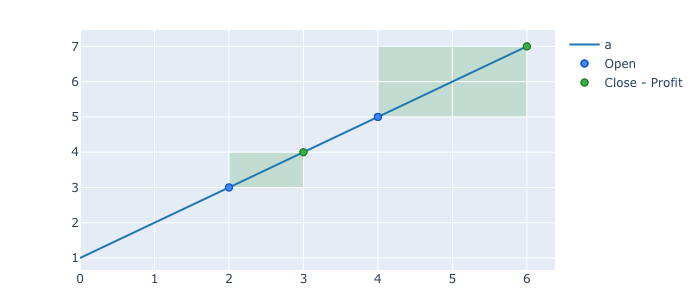

In [76]:
trades['a'].plot().show_png()

In [77]:
print(trades['a'].count)
print(trades.count)

%timeit big_trades.count

2.0
a    2.0
b    2.0
c    2.0
d    2.0
dtype: float64
3.11 ms ± 28.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [78]:
print(trades['a'].duration)
print(trades.duration)

%timeit big_trades.duration

0    NaN
1    NaN
2    NaN
3    1.0
4    NaN
5    NaN
6    2.0
Name: a, dtype: float64
     a    b    c    d
0  NaN  NaN  NaN  NaN
1  NaN  NaN  1.0  NaN
2  NaN  NaN  NaN  NaN
3  1.0  1.0  NaN  NaN
4  NaN  NaN  NaN  2.0
5  NaN  1.0  NaN  NaN
6  2.0  NaN  0.0  0.0
6.37 ms ± 54.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [79]:
print(trades['a'].avg_duration)
print(trades.avg_duration)

%timeit big_trades.avg_duration

1 days 12:00:00
a   1 days 12:00:00
b   1 days 00:00:00
c   0 days 12:00:00
d   1 days 00:00:00
dtype: timedelta64[ns]
11.5 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [80]:
print(trades['a'].max_duration)
print(trades.max_duration)

%timeit big_trades.max_duration

2 days 00:00:00
a   2 days
b   1 days
c   1 days
d   2 days
dtype: timedelta64[ns]
11.9 ms ± 860 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [81]:
print(trades['a'].coverage)
print(trades.coverage)

%timeit big_trades.coverage

0.42857142857142855
a    0.428571
b    0.285714
c    0.142857
d    0.285714
dtype: float64
4.6 ms ± 65.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [82]:
print(trades['a'].pnl)
print(trades.pnl)

%timeit big_trades.pnl

0          NaN
1          NaN
2          NaN
3    30.693069
4          NaN
5          NaN
6    48.654054
Name: a, dtype: float64
           a          b          c         d
0        NaN        NaN        NaN       NaN
1        NaN        NaN  96.039604       NaN
2        NaN        NaN        NaN       NaN
3  30.693069 -15.983027        NaN       NaN
4        NaN        NaN        NaN -1.980198
5        NaN -18.134357        NaN       NaN
6  48.654054        NaN  -1.940986 -0.970493
6.32 ms ± 67.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [83]:
print(trades['a'].min_pnl)
print(trades.min_pnl)

%timeit big_trades.min_pnl

30.69306931
a    30.693069
b   -18.134357
c    -1.940986
d    -1.980198
dtype: float64
4.59 ms ± 67.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [84]:
print(trades['a'].max_pnl)
print(trades.max_pnl)

%timeit big_trades.max_pnl

48.65405351000001
a    48.654054
b   -15.983027
c    96.039604
d    -0.970493
dtype: float64
4.56 ms ± 63.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [85]:
print(trades['a'].avg_pnl)
print(trades.avg_pnl)

%timeit big_trades.avg_pnl

39.673561410000005
a    39.673561
b   -17.058692
c    47.049309
d    -1.475346
dtype: float64
4.35 ms ± 17 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [86]:
print(trades['a'].total_pnl)
print(trades.total_pnl)

%timeit big_trades.total_pnl

79.34712282000001
a    79.347123
b   -34.117383
c    94.098618
d    -2.950691
dtype: float64
4.42 ms ± 63.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [87]:
print(trades['a'].returns)
print(trades.returns)

%timeit big_trades.returns

0         NaN
1         NaN
2         NaN
3    0.306931
4         NaN
5         NaN
6    0.372277
Name: a, dtype: float64
          a         b         c         d
0       NaN       NaN       NaN       NaN
1       NaN       NaN  0.960396       NaN
2       NaN       NaN       NaN       NaN
3  0.306931 -0.159830       NaN       NaN
4       NaN       NaN       NaN -0.019802
5       NaN -0.215842       NaN       NaN
6  0.372277       NaN -0.009901 -0.009901
6.35 ms ± 81 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [88]:
print(trades['a'].min_return)
print(trades.min_return)

%timeit big_trades.min_return

0.3069306931
a    0.306931
b   -0.215842
c   -0.009901
d   -0.019802
dtype: float64
4.47 ms ± 36 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [89]:
print(trades['a'].max_return)
print(trades.max_return)

%timeit big_trades.max_return

0.37227722766262084
a    0.372277
b   -0.159830
c    0.960396
d   -0.009901
dtype: float64
4.48 ms ± 71.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [90]:
print(trades['a'].avg_return)
print(trades.avg_return)

%timeit big_trades.avg_return

0.3396039603813104
a    0.339604
b   -0.187836
c    0.475248
d   -0.014851
dtype: float64
4.38 ms ± 59.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [91]:
print(trades['a'].sqn)
print(trades.sqn)

%timeit big_trades.sqn

4.4177491576435965
a     4.417749
b   -15.858742
c     0.960380
d    -2.922330
dtype: float64
5.19 ms ± 54.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [92]:
print(trades['a'].winning.records)
print(trades.winning['a'].records)
print(trades.winning.records)

   col  idx       size  open_idx  open_price  open_fees  close_idx  \
0    0    3  33.003300         2         3.0   0.990099          3   
1    0    6  25.879816         4         5.0   1.293991          6   

   close_price  close_fees        pnl    return  status  position_idx  
0          4.0    1.320132  30.693069  0.306931       1             0  
1          7.0    1.811587  48.654054  0.372277       1             1  
   col  idx       size  open_idx  open_price  open_fees  close_idx  \
0    0    3  33.003300         2         3.0   0.990099          3   
1    0    6  25.879816         4         5.0   1.293991          6   

   close_price  close_fees        pnl    return  status  position_idx  
0          4.0    1.320132  30.693069  0.306931       1             0  
1          7.0    1.811587  48.654054  0.372277       1             1  
   col  idx       size  open_idx  open_price  open_fees  close_idx  \
0    0    3  33.003300         2         3.0   0.990099          3   
1    0

In [93]:
print(trades['a'].losing.records)
print(trades.losing['a'].records)
print(trades.losing.records)

Empty DataFrame
Columns: [col, idx, size, open_idx, open_price, open_fees, close_idx, close_price, close_fees, pnl, return, status, position_idx]
Index: []
Empty DataFrame
Columns: [col, idx, size, open_idx, open_price, open_fees, close_idx, close_price, close_fees, pnl, return, status, position_idx]
Index: []
   col  idx        size  open_idx  open_price  open_fees  close_idx  \
0    1    3   14.144272         2         7.0   0.990099          3   
1    1    5   16.637024         4         5.0   0.831851          5   
2    2    6  194.098618         6         1.0   1.940986          6   
3    3    4   49.504950         2         2.0   0.990099          4   
4    3    6   24.262327         6         4.0   0.970493          6   

   close_price  close_fees        pnl    return  status  position_idx  
0          6.0    0.848656 -15.983027 -0.159830       1             2  
1          4.0    0.665481 -18.134357 -0.215842       1             3  
2          1.0    0.000000  -1.940986 -0.0099

In [94]:
%timeit big_trades.winning

17 ms ± 3.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [95]:
%timeit big_trades.losing

17.7 ms ± 3.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [96]:
print(trades['a'].win_rate)
print(trades.win_rate)

%timeit big_trades.win_rate

1.0
a    1.0
b    0.0
c    0.5
d    0.0
dtype: float64
22.2 ms ± 3.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [97]:
print(trades['a'].profit_factor)
print(trades.profit_factor)

%timeit big_trades.profit_factor

inf
a          inf
b     0.000000
c    49.479798
d     0.000000
dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/records/events.py:347: RuntimeWarning:

divide by zero encountered in true_divide



43.7 ms ± 5.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [98]:
print(trades['a'].expectancy)
print(trades.expectancy)

%timeit big_trades.expectancy

39.673561410000005
a    39.673561
b   -17.058692
c    47.049309
d    -1.475346
dtype: float64
67.9 ms ± 6.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [99]:
print(trades['a'].status)
print(trades.status)

%timeit big_trades.status

0    NaN
1    NaN
2    NaN
3    1.0
4    NaN
5    NaN
6    1.0
Name: a, dtype: float64
     a    b    c    d
0  NaN  NaN  NaN  NaN
1  NaN  NaN  1.0  NaN
2  NaN  NaN  NaN  NaN
3  1.0  1.0  NaN  NaN
4  NaN  NaN  NaN  1.0
5  NaN  1.0  NaN  NaN
6  1.0  NaN  0.0  0.0
5.9 ms ± 151 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [100]:
print(trades['a'].closed_rate)
print(trades.closed_rate)

%timeit big_trades.closed_rate

1.0
a    1.0
b    1.0
c    0.5
d    0.5
dtype: float64
39.2 ms ± 14.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [101]:
print(trades['a'].open.records)
print(trades.open['a'].records)
print(trades.open.records)

Empty DataFrame
Columns: [col, idx, size, open_idx, open_price, open_fees, close_idx, close_price, close_fees, pnl, return, status, position_idx]
Index: []
Empty DataFrame
Columns: [col, idx, size, open_idx, open_price, open_fees, close_idx, close_price, close_fees, pnl, return, status, position_idx]
Index: []
   col  idx        size  open_idx  open_price  open_fees  close_idx  \
0    2    6  194.098618         6         1.0   1.940986          6   
1    3    6   24.262327         6         4.0   0.970493          6   

   close_price  close_fees       pnl    return  status  position_idx  
0          1.0         0.0 -1.940986 -0.009901       0             5  
1          4.0         0.0 -0.970493 -0.009901       0             7  


In [102]:
print(trades['a'].closed.records)
print(trades.closed['a'].records)
print(trades.closed.records)

   col  idx       size  open_idx  open_price  open_fees  close_idx  \
0    0    3  33.003300         2         3.0   0.990099          3   
1    0    6  25.879816         4         5.0   1.293991          6   

   close_price  close_fees        pnl    return  status  position_idx  
0          4.0    1.320132  30.693069  0.306931       1             0  
1          7.0    1.811587  48.654054  0.372277       1             1  
   col  idx       size  open_idx  open_price  open_fees  close_idx  \
0    0    3  33.003300         2         3.0   0.990099          3   
1    0    6  25.879816         4         5.0   1.293991          6   

   close_price  close_fees        pnl    return  status  position_idx  
0          4.0    1.320132  30.693069  0.306931       1             0  
1          7.0    1.811587  48.654054  0.372277       1             1  
   col  idx       size  open_idx  open_price  open_fees  close_idx  \
0    0    3  33.003300         2         3.0   0.990099          3   
1    0

In [103]:
%timeit big_trades.open # less records

3.26 ms ± 30.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [104]:
%timeit big_trades.closed # almost all

50.7 ms ± 408 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Positions

In [105]:
from vectorbt.records import Positions

In [106]:
positions = Positions.from_orders(orders)
print(positions.records_arr.shape)

(8,)


In [107]:
big_positions = Positions.from_orders(big_orders)
print(big_positions.records_arr.shape)

(500000,)


In [108]:
%timeit Positions.from_orders(big_orders)

22.7 ms ± 5.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [109]:
print(positions.records)
print(positions['a'].records)
print(positions['b'].records)
print(positions['c'].records)
print(positions['d'].records)

   col  idx        size  open_idx  open_price  open_fees  close_idx  \
0    0    3   33.003300         2         3.0   0.990099          3   
1    0    6   25.879816         4         5.0   1.293991          6   
2    1    3   14.144272         2         7.0   0.990099          3   
3    1    5   16.637024         4         5.0   0.831851          5   
4    2    1   99.009901         0         1.0   0.990099          1   
5    2    6  194.098618         6         1.0   1.940986          6   
6    3    4   49.504950         2         2.0   0.990099          4   
7    3    6   24.262327         6         4.0   0.970493          6   

   close_price  close_fees         pnl    return  status  
0          4.0    1.320132   30.693069  0.306931       1  
1          7.0    1.811587   48.654054  0.372277       1  
2          6.0    0.848656  -15.983027 -0.159830       1  
3          4.0    0.665481  -18.134357 -0.215842       1  
4          2.0    1.980198   96.039604  0.960396       1  
5     

In [110]:
positions['c'].records_arr

array([(0, 1,  99.00990099, 0, 1., 0.99009901, 1, 2., 1.98019802,  96.03960396, 0.96039604, 1),
       (0, 6, 194.09861778, 6, 1., 1.94098618, 6, 4., 0.        , 580.35486716, 2.96039604, 0)],
      dtype={'names':['col','idx','size','open_idx','open_price','open_fees','close_idx','close_price','close_fees','pnl','return','status'], 'formats':['<i8','<i8','<f8','<i8','<f8','<f8','<i8','<f8','<f8','<f8','<f8','<i8'], 'offsets':[0,8,16,24,32,40,48,56,64,72,80,88], 'itemsize':96, 'aligned':True})

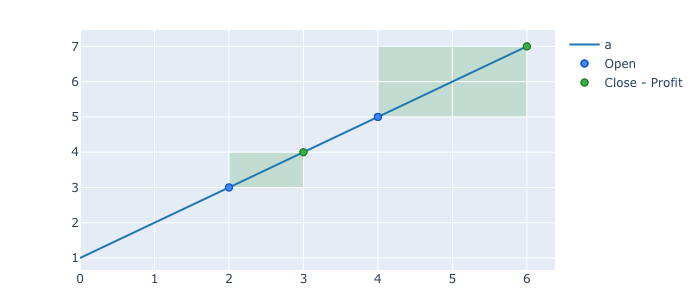

In [111]:
positions['a'].plot().show_png()

In [112]:
print(positions['a'].count)
print(positions.count)

%timeit big_positions.count

2.0
a    2.0
b    2.0
c    2.0
d    2.0
dtype: float64
3 ms ± 44.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [113]:
print(positions['a'].duration)
print(positions.duration)

%timeit big_positions.duration

0    NaN
1    NaN
2    NaN
3    1.0
4    NaN
5    NaN
6    2.0
Name: a, dtype: float64
     a    b    c    d
0  NaN  NaN  NaN  NaN
1  NaN  NaN  1.0  NaN
2  NaN  NaN  NaN  NaN
3  1.0  1.0  NaN  NaN
4  NaN  NaN  NaN  2.0
5  NaN  1.0  NaN  NaN
6  2.0  NaN  0.0  0.0
6.21 ms ± 56.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [114]:
print(positions['a'].avg_duration)
print(positions.avg_duration)

%timeit big_positions.avg_duration

1 days 12:00:00
a   1 days 12:00:00
b   1 days 00:00:00
c   0 days 12:00:00
d   1 days 00:00:00
dtype: timedelta64[ns]
11.3 ms ± 78.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [115]:
print(positions['a'].max_duration)
print(positions.max_duration)

%timeit big_positions.max_duration

2 days 00:00:00
a   2 days
b   1 days
c   1 days
d   2 days
dtype: timedelta64[ns]
11.3 ms ± 91.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [116]:
print(positions['a'].coverage)
print(positions.coverage)

%timeit big_positions.coverage

0.42857142857142855
a    0.428571
b    0.285714
c    0.142857
d    0.285714
dtype: float64
4.35 ms ± 58.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [117]:
print(positions['a'].pnl)
print(positions.pnl)

%timeit big_positions.pnl

0          NaN
1          NaN
2          NaN
3    30.693069
4          NaN
5          NaN
6    48.654054
Name: a, dtype: float64
           a          b           c         d
0        NaN        NaN         NaN       NaN
1        NaN        NaN   96.039604       NaN
2        NaN        NaN         NaN       NaN
3  30.693069 -15.983027         NaN       NaN
4        NaN        NaN         NaN -1.980198
5        NaN -18.134357         NaN       NaN
6  48.654054        NaN  580.354867 -0.970493
6.04 ms ± 57.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [118]:
print(positions['a'].min_pnl)
print(positions.min_pnl)

%timeit big_positions.min_pnl

30.69306931
a    30.693069
b   -18.134357
c    96.039604
d    -1.980198
dtype: float64
4.32 ms ± 48.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [119]:
print(positions['a'].max_pnl)
print(positions.max_pnl)

%timeit big_positions.max_pnl

48.65405351000001
a     48.654054
b    -15.983027
c    580.354867
d     -0.970493
dtype: float64
4.35 ms ± 55.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [120]:
print(positions['a'].avg_pnl)
print(positions.avg_pnl)

%timeit big_positions.avg_pnl

39.673561410000005
a     39.673561
b    -17.058692
c    338.197236
d     -1.475346
dtype: float64
4.16 ms ± 29.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [121]:
print(positions['a'].total_pnl)
print(positions.total_pnl)

%timeit big_positions.total_pnl

79.34712282000001
a     79.347123
b    -34.117383
c    676.394471
d     -2.950691
dtype: float64
4.18 ms ± 39.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [122]:
print(positions['a'].returns)
print(positions.returns)

%timeit big_positions.returns

0         NaN
1         NaN
2         NaN
3    0.306931
4         NaN
5         NaN
6    0.372277
Name: a, dtype: float64
          a         b         c         d
0       NaN       NaN       NaN       NaN
1       NaN       NaN  0.960396       NaN
2       NaN       NaN       NaN       NaN
3  0.306931 -0.159830       NaN       NaN
4       NaN       NaN       NaN -0.019802
5       NaN -0.215842       NaN       NaN
6  0.372277       NaN  2.960396 -0.009901
6.07 ms ± 61 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [123]:
print(positions['a'].min_return)
print(positions.min_return)

%timeit big_positions.min_return

0.3069306931
a    0.306931
b   -0.215842
c    0.960396
d   -0.019802
dtype: float64
4.31 ms ± 26.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [124]:
print(positions['a'].max_return)
print(positions.max_return)

%timeit big_positions.max_return

0.37227722766262084
a    0.372277
b   -0.159830
c    2.960396
d   -0.009901
dtype: float64
4.34 ms ± 35.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [125]:
print(positions['a'].avg_return)
print(positions.avg_return)

%timeit big_positions.avg_return

0.3396039603813104
a    0.339604
b   -0.187836
c    1.960396
d   -0.014851
dtype: float64
4.17 ms ± 30.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [126]:
print(positions['a'].sqn)
print(positions.sqn)

%timeit big_positions.sqn

4.4177491576435965
a     4.417749
b   -15.858742
c     1.396600
d    -2.922330
dtype: float64
5.52 ms ± 266 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [127]:
print(positions['a'].winning.records)
print(positions.winning['a'].records)
print(positions.winning.records)

   col  idx       size  open_idx  open_price  open_fees  close_idx  \
0    0    3  33.003300         2         3.0   0.990099          3   
1    0    6  25.879816         4         5.0   1.293991          6   

   close_price  close_fees        pnl    return  status  
0          4.0    1.320132  30.693069  0.306931       1  
1          7.0    1.811587  48.654054  0.372277       1  
   col  idx       size  open_idx  open_price  open_fees  close_idx  \
0    0    3  33.003300         2         3.0   0.990099          3   
1    0    6  25.879816         4         5.0   1.293991          6   

   close_price  close_fees        pnl    return  status  
0          4.0    1.320132  30.693069  0.306931       1  
1          7.0    1.811587  48.654054  0.372277       1  
   col  idx        size  open_idx  open_price  open_fees  close_idx  \
0    0    3   33.003300         2         3.0   0.990099          3   
1    0    6   25.879816         4         5.0   1.293991          6   
2    2    1   99.

In [128]:
print(positions['a'].losing.records)
print(positions.losing['a'].records)
print(positions.losing.records)

Empty DataFrame
Columns: [col, idx, size, open_idx, open_price, open_fees, close_idx, close_price, close_fees, pnl, return, status]
Index: []
Empty DataFrame
Columns: [col, idx, size, open_idx, open_price, open_fees, close_idx, close_price, close_fees, pnl, return, status]
Index: []
   col  idx       size  open_idx  open_price  open_fees  close_idx  \
0    1    3  14.144272         2         7.0   0.990099          3   
1    1    5  16.637024         4         5.0   0.831851          5   
2    3    4  49.504950         2         2.0   0.990099          4   
3    3    6  24.262327         6         4.0   0.970493          6   

   close_price  close_fees        pnl    return  status  
0          6.0    0.848656 -15.983027 -0.159830       1  
1          4.0    0.665481 -18.134357 -0.215842       1  
2          2.0    0.990099  -1.980198 -0.019802       1  
3          4.0    0.000000  -0.970493 -0.009901       0  


In [129]:
%timeit big_positions.winning

15.9 ms ± 2.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [130]:
%timeit big_positions.losing

16.8 ms ± 3.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [131]:
print(positions['a'].win_rate)
print(positions.win_rate)

%timeit big_positions.win_rate

1.0
a    1.0
b    0.0
c    1.0
d    0.0
dtype: float64
20.6 ms ± 2.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [132]:
print(positions['a'].profit_factor)
print(positions.profit_factor)

%timeit big_positions.profit_factor

inf
a    inf
b    0.0
c    inf
d    0.0
dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/records/events.py:347: RuntimeWarning:

divide by zero encountered in true_divide



45.2 ms ± 6.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [133]:
print(positions['a'].expectancy)
print(positions.expectancy)

%timeit big_positions.expectancy

39.673561410000005
a     39.673561
b    -17.058692
c    338.197236
d     -1.475346
dtype: float64
63.7 ms ± 6.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [134]:
print(positions['a'].status)
print(positions.status)

%timeit big_positions.status

0    NaN
1    NaN
2    NaN
3    1.0
4    NaN
5    NaN
6    1.0
Name: a, dtype: float64
     a    b    c    d
0  NaN  NaN  NaN  NaN
1  NaN  NaN  1.0  NaN
2  NaN  NaN  NaN  NaN
3  1.0  1.0  NaN  NaN
4  NaN  NaN  NaN  1.0
5  NaN  1.0  NaN  NaN
6  1.0  NaN  0.0  0.0
5.35 ms ± 49.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [135]:
print(positions['a'].closed_rate)
print(positions.closed_rate)

%timeit big_positions.closed_rate

1.0
a    1.0
b    1.0
c    0.5
d    0.5
dtype: float64
31.6 ms ± 6.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [136]:
print(positions['a'].open.records)
print(positions.open['a'].records)
print(positions.open.records)

Empty DataFrame
Columns: [col, idx, size, open_idx, open_price, open_fees, close_idx, close_price, close_fees, pnl, return, status]
Index: []
Empty DataFrame
Columns: [col, idx, size, open_idx, open_price, open_fees, close_idx, close_price, close_fees, pnl, return, status]
Index: []
   col  idx        size  open_idx  open_price  open_fees  close_idx  \
0    2    6  194.098618         6         1.0   1.940986          6   
1    3    6   24.262327         6         4.0   0.970493          6   

   close_price  close_fees         pnl    return  status  
0          4.0         0.0  580.354867  2.960396       0  
1          4.0         0.0   -0.970493 -0.009901       0  


In [137]:
print(positions['a'].closed.records)
print(positions.closed['a'].records)
print(positions.closed.records)

   col  idx       size  open_idx  open_price  open_fees  close_idx  \
0    0    3  33.003300         2         3.0   0.990099          3   
1    0    6  25.879816         4         5.0   1.293991          6   

   close_price  close_fees        pnl    return  status  
0          4.0    1.320132  30.693069  0.306931       1  
1          7.0    1.811587  48.654054  0.372277       1  
   col  idx       size  open_idx  open_price  open_fees  close_idx  \
0    0    3  33.003300         2         3.0   0.990099          3   
1    0    6  25.879816         4         5.0   1.293991          6   

   close_price  close_fees        pnl    return  status  
0          4.0    1.320132  30.693069  0.306931       1  
1          7.0    1.811587  48.654054  0.372277       1  
   col  idx       size  open_idx  open_price  open_fees  close_idx  \
0    0    3  33.003300         2         3.0   0.990099          3   
1    0    6  25.879816         4         5.0   1.293991          6   
2    1    3  14.1442

In [138]:
%timeit big_positions.open # less records

3.03 ms ± 50.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [139]:
%timeit big_positions.closed # almost all

46.6 ms ± 685 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
